In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import pandas as pd
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools
import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime

from scipy.stats import mode
dy_name = 'melt_qc_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    cpy.makedir(private_out)

# Test Replication Rate versus VCF annotations in SpeedSeq Variants

In [4]:
def plot_discordance_vs_cat(df,labels, colors, thresholds, num_sites, cat, letter_label):
    min_thresh = min(thresholds)
    max_thresh = max(thresholds)
    
    
    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(1,1, figsize = (8,5))
        
        # color bar plotting
        divider = make_axes_locatable(ax)
        axDivY = divider.append_axes( 'right', size=0.2, pad= 0.1)
        cmap = plt.cm.PuBu
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_thresh, 
                                                                 vmax=max_thresh))
        sm.set_array([]) 
        cbar = plt.colorbar(sm, cax = axDivY)
        cbar.set_ticks(thresholds)
        
        patches = mpltools.get_legend_patches(labels, markeredgecolor=colors,
                                     markerfacecolor='white', 
                                              markeredgewidth=2, markersize=10)
        
         
        
        for c, l in zip(colors, labels):
            tdf = df[df.SVTYPE == l]
            ax.scatter(df[num_sites], df.mean_replication_rate, 
                       c = df.color, alpha=0.9, lw = 2, s = 150, edgecolor = c, label = l)
            
        leg = ax.legend(handles = patches, bbox_to_anchor = (1,0), loc='lower right',ncol = 1,
                             fontsize= 11, title = 'SVTYPE', frameon=True, borderaxespad=0)
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        plt.setp(leg.get_title(), fontsize=12, color='Black')
        
        ax.set(ylabel = 'mean replication rate', xlabel = 'number of total sites')      
        fig.text(0.98, 0.5, "{} threshold".format(cat), 
                 rotation= 90, horizontalalignment='center', 
                 verticalalignment='center', fontsize = 15)
        
        
        xlim = ax.get_xlim()
        ax.axhline(0.9, xlim[0], xlim[1], linestyle = '--', )
        
        fig.text(0.05, 0.95, "{}".format(letter_label), 
                 horizontalalignment='center', verticalalignment='center', 
                 fontsize = 18, fontweight='bold')
        return ax
        

In [5]:
def concat_cols(df, cols, sep='_', name=False, inplace=False):
    if not name:
        name = sep.join(cols)
    if not inplace:
        df = df.copy()
    col_lists = zip(*[df[c].astype(str).tolist() for c in cols])
    concat = [sep.join(i) for i in col_lists]
    df[name] = concat
    return df

In [21]:
def expand_filter_col(df): 
    filters = df.FILTER.tolist()
    indexes = df.index.tolist()
    data = []
    
    cols = ['rSD', 's25', 'hDP', 'lc', 'PASS']
    
    for x in filters:
        out_line = [False, False, False, False, False]
        F = x.split(';')
        for i in F:
            try:
                ind = cols.index(i)
                out_line[ind] = True
            except:
                pass

    
        data.append(out_line)
    
    tdf = pd.DataFrame(data, index=indexes, columns=cols)
    df = df.join(tdf)
    df['NO_FILTER'] = False
    
    return df

In [7]:
def filter_conditionally(df, filter_group):
    
    tdf = df.copy()
    for i in filter_group:
        # filter each thing
        
        if i == 'PASS':
            tdf = tdf[tdf[i]== True]
        else:
            tdf = tdf[tdf[i]== False]
    
    return tdf

In [9]:
def filter_thresholds(df, filter_group, thresh):
    
    tdf = df.copy()
    tdf = tdf[tdf[filter_group].astype(float) >= thresh]
    
    return tdf

In [10]:
def filtering_df_categories(rr_df, info, thresholds, color_dict, subcat = False):
    
    def add_num_sites_total(df, info, thresholds):
        data = []
        for i in thresholds:
            tdf = filter_conditionally(info, i)
            s = tdf.shape[0]
            data.append(s)
        df = df.copy()
        df['num_sites_all'] = data
        return df
    
   
    dfs = []
    
    for g, df in rr_df.groupby('SVTYPE'):
        data = []
        for thresh in thresholds:
            tdf = df.pipe(filter_conditionally, thresh)
            m = tdf.replication_rate.astype(float).mean()
            s = tdf.shape[0]
            c = color_dict[",".join(thresh)]
            data.append([thresh, s, m, g, c])
    
    
            
        filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 
                                             'mean_replication_rate', 'SVTYPE', 'color'])
        info_subcat = info[info.SVTYPE == g]
        filtDf = filtDf.pipe(add_num_sites_total, info_subcat, thresholds)
        
        dfs.append(filtDf)
    
    # with no subtypes
    
    data = []
    for thresh in thresholds:
        tdf = rr_df.pipe(filter_conditionally, thresh)
        m = tdf.replication_rate.astype(float).mean()
        s = tdf.shape[0]
        c = color_dict[",".join(thresh)]
        data.append([thresh, s, m, 'all', c])
    filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 
                                         'mean_replication_rate', 'SVTYPE', 'color'])
    filtDf = filtDf.pipe(add_num_sites_total, info, thresholds)   
    dfs.append(filtDf)
    df_out = pd.concat(dfs)
        
    return df_out 

In [11]:
def filtering_df_thresholds(rr_df, info, cat, thresholds, color_dict, subcat = False):
    
    def add_num_sites_total(df, info,  cat, thresholds):
        data = []
        for i in thresholds:
            tdf = filter_thresholds(info, cat, i)
            s = tdf.shape[0]
            data.append(s)
        df = df.copy()
        df['num_sites_all'] = data
        return df
    
   
    dfs = []
    
    for g, df in rr_df.groupby('SVTYPE'):
        data = []
        for thresh in thresholds:
            tdf = df.pipe(filter_thresholds, cat, thresh)
            m = tdf.replication_rate.astype(float).mean()
            s = tdf.shape[0]
            data.append([thresh, s, m, g])
    
    
            
        filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 
                                             'mean_replication_rate', 'SVTYPE'])
        info_subcat = info[info.SVTYPE == g]
        filtDf = filtDf.pipe(add_num_sites_total, info_subcat, cat, thresholds)
        dfs.append(filtDf)
    
    # with no subtypes
    
    data = []
    for thresh in thresholds:
        tdf = rr_df.pipe(filter_thresholds, cat, thresh)
        m = tdf.replication_rate.astype(float).mean()
        s = tdf.shape[0]
        data.append([thresh, s, m, 'all'])
    filtDf = pd.DataFrame(data, columns=['thresh', 'num_sites', 
                                         'mean_replication_rate', 'SVTYPE'])
    filtDf = filtDf.pipe(add_num_sites_total, info, cat, thresholds)   
    dfs.append(filtDf)
    df_out = pd.concat(dfs)
    
    df_out['color'] = df_out['thresh'].apply(lambda x: color_dict[x])
        
    return df_out 

In [12]:
def prep_rr_df(df, info):
    df = df.copy()
    df = df.join(info.FILTER)
    df = df.join(info.ASSESS)
    df = df[df.number_pairs_with_var > 0]
    df = df[df['name'].isin(info.index.tolist())]
    df = df.pipe(expand_filter_col)
    return df

def prep_info(df):
    df = df.copy()
    df['NNREF'] = df['NNREF'].astype(int)
    df = df[df.NNREF > 0]
    df["#CHROM"] = df['#CHROM'].astype(str)
    df = df[df["#CHROM"].isin(CM.normal_Chrs)]
    df = df.pipe(expand_filter_col)
    return df

In [22]:
melt_info_annot = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_processing_pipeline/i2QTL_V2/melt_info_annot.pkl').pipe(prep_info)

In [23]:
rr_per_site_twin = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_processing_pipeline/i2QTL_V2/rr_per_site_twin.pkl').pipe(prep_rr_df, melt_info_annot)

In [24]:
rr_per_site_fib_ipsc = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_processing_pipeline/i2QTL_V2/rr_per_site_fib_ipsc.pkl').pipe(prep_rr_df, melt_info_annot)

In [28]:
def plot_rr_rate_vs_filters(filt_df, labels, colors,labels_filtering, colors_filtering, num_sites, letter_label= '', ax = False):
    
    colors_dict = dict(zip(labels_filtering, colors_filtering))
    with sns.axes_style('ticks'):
        
        if not ax:
            fig, ax = plt.subplots(1,1, figsize = (10,6))

        # color bar plotting
        divider = make_axes_locatable(ax)
        axDivY = divider.append_axes( 'right', size=1.6, pad= 0.1)
        
        
        
        patches = get_legend_patches(labels_filtering, markerfacecolor=colors_filtering, markersize=10)
        leg = axDivY.legend(handles=patches, fontsize=11,mode = 'expand', title = 'Filter Categories', 
                            bbox_to_anchor = (0,0,1,1),loc='upper left',ncol=1, borderaxespad=0, frameon=True)
    
        plt.setp(leg.get_title(),fontsize=12, color='Black')
        
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        a = axDivY.add_artist(leg)
        
        for c, l in zip(colors, labels):
            df = filt_df[filt_df.SVTYPE == l]
            ax.scatter(df[num_sites], df.mean_replication_rate, c = df.color, alpha=0.9, lw = 2, s = 150, edgecolor = c, label = l)
        
        # note that you can get the handles like this from an axes
        # handles, labels = ax.get_legend_handles_labels()
    
        # get patches to make a leg
        patches = get_legend_patches(labels, markeredgecolor=colors,
                                     markerfacecolor='white', markeredgewidth=2, markersize=10)
        
        
        # mode expand on each legend will force them to be the same dimensions, width wise
        leg2 = axDivY.legend(handles = patches, bbox_to_anchor = (0,0,1,1), loc='lower left',ncol = 1,
                             fontsize= 11, title = 'SVTYPE', frameon=True, mode = 'expand', borderaxespad=0)
        plt.setp(leg2.get_title(), fontsize=12, color='Black')
        
        leg2.get_frame().set_facecolor('white')
        leg2.get_frame().set_edgecolor('black')
        
        
        ax.set(ylabel = 'mean replication rate', xlabel = 'no. variant sites after filtering')
        axDivY.set_axis_off()
        fig.text(0.05, 0.95, "{}".format(letter_label), horizontalalignment='center', verticalalignment='center', fontsize = 18, fontweight='bold')
        return ax, leg, patches

In [35]:
labels_filtering = ['NO_FILTER','rSD', 's25', 'hDP', 'lc', 'lc,hDP', 'rSD,hDP', 'lc,s25','rSD,lc', 'rSD,hDP,lc', 'hDP,lc,s25', 'rSD,hDP,s25' ,'rSD,s25,hDP,lc']
colors_filtering = sns.color_palette("hls", len(labels_filtering))
colors_filtering[0] = 'white'
color_dict = dict(zip(labels_filtering, colors_filtering))
categories = [i.split(',') for i in labels_filtering] 
filt_df_twin = filtering_df_categories(rr_per_site_twin, melt_info_annot, categories, color_dict)

labs_svtypes = ['ALU', 'LINE1', 'SVA', 'all']
colors_svtypes = ['#00aedb', '#d11141', '#00b159', 'black']

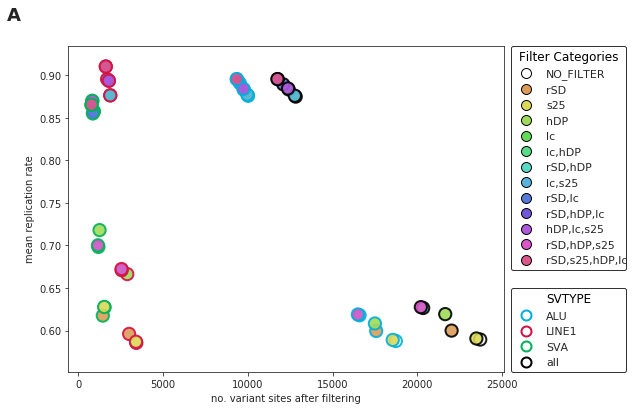

In [30]:
ax,leg, p = plot_rr_rate_vs_filters(filt_df, labs_svtypes, colors_svtypes, labels_filtering, colors_filtering, 'num_sites_all', letter_label='A')

In [36]:
labels_filtering = ['NO_FILTER','rSD', 's25', 'hDP', 'lc', 'lc,hDP', 'rSD,hDP', 'lc,s25','rSD,lc', 'rSD,hDP,lc', 'hDP,lc,s25', 'rSD,hDP,s25' ,'rSD,s25,hDP,lc']
colors_filtering = sns.color_palette("hls", len(labels_filtering))
colors_filtering[0] = 'white'
color_dict = dict(zip(labels_filtering, colors_filtering))
categories = [i.split(',') for i in labels_filtering] 
filt_df_ipsc = filtering_df_categories(rr_per_site_fib_ipsc, melt_info_annot, categories, color_dict)

labs_svtypes = ['ALU', 'LINE1', 'SVA', 'all']
colors_svtypes = ['#00aedb', '#d11141', '#00b159', 'black']

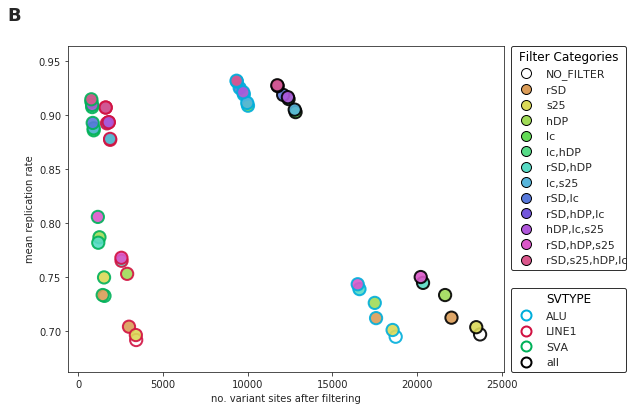

In [34]:
ax,leg, p = plot_rr_rate_vs_filters(filt_df, labs_svtypes, colors_svtypes, labels_filtering, colors_filtering, 'num_sites_all', letter_label='B')

# Save Data for Supplement

In [37]:
CM.save_dataframe('melt_rr_cat_twins', filt_df_twin, private_out)

melt_rr_cat_twins = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_rr_cat_twins.pkl')
melt_rr_cat_twins = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_rr_cat_twins.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/load_pickled_nb_variables.py


In [38]:
CM.save_dataframe('melt_rr_cat_ipsc', filt_df_ipsc, private_out)

melt_rr_cat_ipsc = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_rr_cat_ipsc.pkl')
melt_rr_cat_ipsc = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/melt_rr_cat_ipsc.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/melt_qc_analysis/load_pickled_nb_variables.py


# Testing Association with Quality Tranches 

## 1. Quality Tranches Vs Replication Rate *Before* Applying Other Quality Filters

In [138]:
def prep_rr_df_tranches(df, info):
    df = df.copy()
    df = df[df['name'].isin(info.index.tolist())]
    return df

def prep_info_tranches(df):
    df = df.copy()
    df = df[df.FILTER == 'PASS']
    return df

In [157]:
labels_tranches = [0, 1, 2, 3, 4 ,5]
colors_tranches = sns.color_palette("PuBu", len(labels_tranches))
colors_tranches[0] = 'white'
color_dict_tranches = dict(zip(labels_tranches, colors_tranches))

labs_svtypes = ['ALU', 'LINE1', 'SVA', 'all']
colors_svtypes = ['#00aedb', '#d11141', '#00b159', 'black']

sns.color_palette('PuBu', len(labels_tranches))

info_filt = melt_info_annot.pipe(prep_info_tranches)
rr_filt = rr_per_site_twin.pipe(prep_rr_df_tranches, info_filt)

filt_df_tranches_original = filtering_df_thresholds(rr_per_site_twin, melt_info_annot, 'ASSESS', labels_tranches, color_dict_tranches)

filt_df_tranches = filtering_df_thresholds(rr_filt, info_filt, 'ASSESS', labels_tranches, color_dict_tranches)

Text(0.5,1,u'Replication Rate Vs Quality Tranch Score, No Filtering')

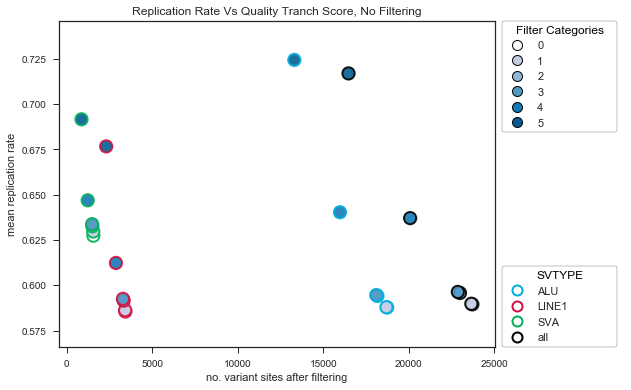

In [175]:
ax2,leg, p = plot_rr_rate_vs_filters(filt_df_tranches_original, labs_svtypes, colors_svtypes, labels_tranches, colors_tranches, 'num_sites_all', letter_label='B')
ax2.set_title('Replication Rate Vs Quality Tranch Score, No Filtering')

Text(0.5,1,u'Replication Rate Vs Quality Tranch Score, After Suggested Filters')

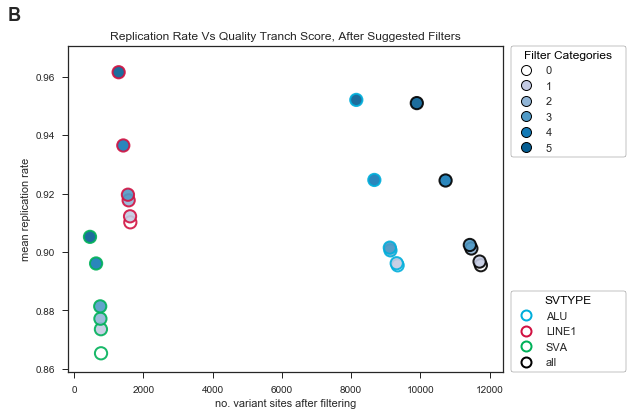

In [176]:
ax2,leg, p = plot_rr_rate_vs_filters(filt_df_tranches, labs_svtypes, colors_svtypes, labels_tranches, colors_tranches, 'num_sites_all', letter_label='B')
ax2.set_title('Replication Rate Vs Quality Tranch Score, After Suggested Filters')

## 2. Quality Tranches Vs Replication Rate *Before* Applying Other Quality Filters

In [209]:
labels_tranches = [0, 1, 2, 3, 4 ,5]
colors_tranches = sns.color_palette("PuBu", len(labels_tranches))
colors_tranches[0] = 'white'
color_dict_tranches = dict(zip(labels_tranches, colors_tranches))

labs_svtypes = ['ALU', 'LINE1', 'SVA', 'all']
colors_svtypes = ['#00aedb', '#d11141', '#00b159', 'black']

sns.color_palette('PuBu', len(labels_tranches))

info_filt = melt_info_annot.pipe(prep_info_tranches)
rr_filt = rr_per_site_twin.pipe(prep_rr_df_tranches, info_filt)

filt_df_tranches_original = filtering_df_thresholds(rr_per_site_fib_ipsc, melt_info_annot, 'ASSESS', labels_tranches, color_dict_tranches)

filt_df_tranches = filtering_df_thresholds(rr_filt, info_filt, 'ASSESS', labels_tranches, color_dict_tranches)

Text(0.5,1,u'Replication Rate Vs Quality Tranch Score, After Suggested Filters')

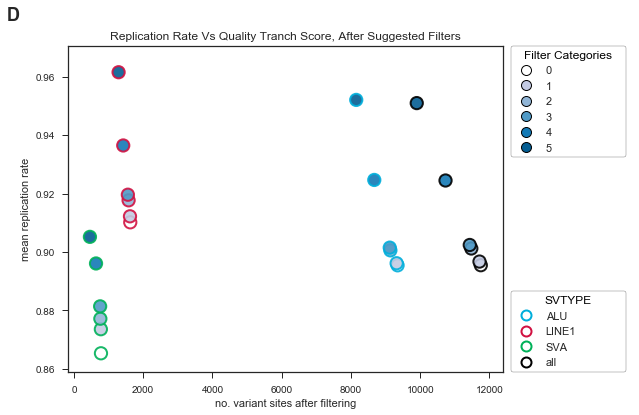

In [212]:
ax2,leg, p = plot_rr_rate_vs_filters(filt_df_tranches, labs_svtypes, colors_svtypes, labels_tranches, colors_tranches, 'num_sites_all', letter_label='D')
ax2.set_title('Replication Rate Vs Quality Tranch Score, After Suggested Filters')

Quality tranched affect replication rate independently of other standard filters employed. Among standard filters, filterin on low complexity ("lc" tag) had the greatest impact on reproducibility